![image](https://github.com/Lexie88rus/iWildCam/raw/master/assets/cover_image.jpg)

Photo by [Sarah Bliss](https://unsplash.com/@squeakypeachphotos?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/s/photos/wild-animals?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)

# iWildCam EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import json

from PIL import Image

import matplotlib.pyplot as plt

## Introduction

....


## Load Data

Get the list of files in the dataset:

In [2]:
! ls ../input/iwildcam-2020-fgvc7

iwildcam2020_megadetector_results.json	sample_submission.csv
iwildcam2020_test_information.json	test
iwildcam2020_train_annotations.json	train


Load the train annotations data:

In [3]:
# setup the directories
DATA_DIR = '../input/iwildcam-2020-fgvc7/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'

# load the megadetector results
megadetector_results = json.load(open(DATA_DIR + 'iwildcam2020_megadetector_results.json'))
#megadetector_results['images'][:2]

# load train images annotations
train_info = json.load(open(DATA_DIR + 'iwildcam2020_train_annotations.json'))
# split json into several pandas dataframes
train_annotations = pd.DataFrame(train_info['annotations'])
train_images = pd.DataFrame(train_info['images'])
train_categories = pd.DataFrame(train_info['categories'])

# load test images info
test_info = json.load(open(DATA_DIR + 'iwildcam2020_test_information.json'))
# split json into several pandas dataframes
test_images = pd.DataFrame(test_info['images'])
test_categories = pd.DataFrame(test_info['categories'])

Look at the dataframes containing the train set annotations:

1. The list of images and corresponding category ids:

In [4]:
train_annotations.head()

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2


2. Train images sequence information (locations of cameras, sequences of images from same locations, image timestamps):

In [5]:
train_images.head()

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,267,2013-08-08 11:45:00.000,96b00332-21bc-11ea-a13a-137349068a90,1,96b004ea-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,1,264,2013-08-01 22:31:00.000,879d74d8-21bc-11ea-a13a-137349068a90,1,879d7654-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,1,45,2013-04-17 11:15:00.000,9017f7aa-21bc-11ea-a13a-137349068a90,1,9017f8cc-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,1,45,2013-04-23 08:26:00.000,90d93c58-21bc-11ea-a13a-137349068a90,1,90d93e38-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,1,45,2013-04-24 13:51:00.000,887cd0ec-21bc-11ea-a13a-137349068a90,1,887cd29a-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


3. The description of categories:

In [6]:
train_categories.head()

,count,id,name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor


## Train Set Statistics

Get the total number of images in the train set:

In [7]:
print('Number of images in the train set is {}'.format(train_annotations.image_id.nunique()))
print('Number of images in the test set is {}'.format(test_images.file_name.nunique()))

Number of images in the train set is 217959
Number of images in the test set is 62894


Visualize train and test sets:

Text(0.5, 1.0, 'Number of images in train and test sets')

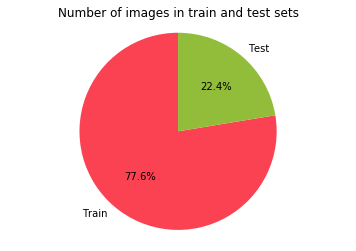

In [8]:
plt.pie([train_annotations.image_id.nunique(), test_images.file_name.nunique()], labels=['Train', 'Test'], autopct='%1.1f%%', 
           startangle=90, colors=['#fa4252', '#91bd3a'])
plt.axis('equal')
plt.title('Number of images in train and test sets')

Let's check the number of animals found per image:

In [9]:
# get the number of counts per image
# sort values in descending order
counts_per_image = train_annotations.groupby(by=['image_id']).sum().reset_index()[['image_id', 'count']].sort_values(by=['count'], ascending=False)
# output top-5
counts_per_image.head(5)

,image_id,count
130497,91d0f146-21bc-11ea-a13a-137349068a90,80
190827,97062316-21bc-11ea-a13a-137349068a90,75
42664,8a28c004-21bc-11ea-a13a-137349068a90,75
39846,89eab214-21bc-11ea-a13a-137349068a90,75
216092,9926a95e-21bc-11ea-a13a-137349068a90,70


In [10]:
# output tail-5
counts_per_image.tail(5)

,image_id,count
75105,8d028ab2-21bc-11ea-a13a-137349068a90,-1
75101,8d0274fa-21bc-11ea-a13a-137349068a90,-1
156729,9415a4e2-21bc-11ea-a13a-137349068a90,-1
175047,959f6226-21bc-11ea-a13a-137349068a90,-1
161439,947c57c8-21bc-11ea-a13a-137349068a90,-1


As wee see, some of the images have 80 counts of animals on them!
Some of the images have negative counts, which probably corresponds to no animals there.

This is a distribution of the count of animals found on the images:

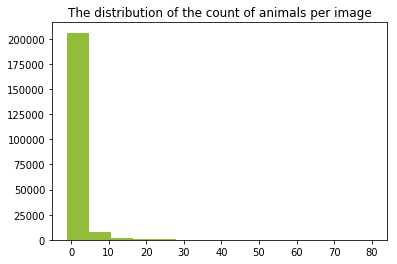

In [11]:
plt.hist(counts_per_image['count'].values, bins=14, color='#91bd3a')
plt.title('The distribution of the count of animals per image')
plt.show()

We can see that:
* most of the images are empty;
* having more than 20 animals on one image is very rare.

## Train Set Images Exploration

Visualize random images from the train set and their categories (just one first category):

In [12]:
def get_first_category(img_id):
    """Find first the image category by id."""
    # get category id
    category_id = train_annotations[train_annotations.image_id == img_id].category_id.values[0]
    # get category name
    category_name = train_categories[train_categories.id == category_id].name.values[0]
    return category_id, category_name

def visualize_image_grid(rows, cols):
    """Visualize random grid of images with the first category."""
    filenames = train_images.file_name.unique()
    
    np.random.seed(42)
    img_idx = np.random.randint(len(filenames), size=rows * cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15,7))
    
    for r in range(rows):
        for c in range(cols):
            # get the image and image id
            filename = filenames[img_idx[rows*r + c]]
            img_id = filename.split('.')[0]
            # get the category
            category_id, category = get_first_category(img_id)
            
            img = Image.open(TRAIN_DIR + filename)
            
            axs[r,c].imshow(img)
            axs[r,c].axis('off')
            axs[r,c].set_title('{}:{}'.format(category_id, category))
            
    plt.suptitle('Train images', fontsize=16)
    plt.show()

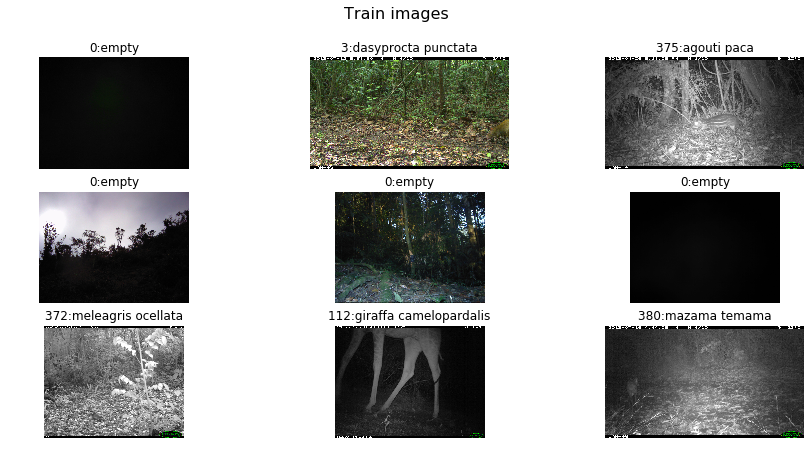

In [13]:
visualize_image_grid(3, 3)

WE can see that there are images of different sizes with different lighting conditions. For some of the images it is hard even for a human to find an animal. 